In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
# Function to remove outliers
def remove_outliers(df, threshold=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df < (Q1 - threshold * IQR)) | (df > (Q3 + threshold * IQR))).any(axis=1)]
    return df

In [29]:
df = pd.read_csv('data/creditcard.csv')

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [30]:
# Standardize the Amount and Time columns
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [31]:
# Separate the minority and majority classes
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

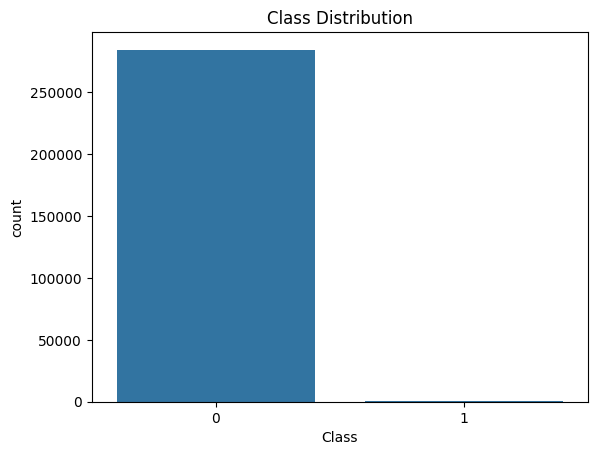

In [32]:
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

In [33]:
# Remove outliers
df_majority_cleaned = remove_outliers(non_fraud, threshold=1.5)

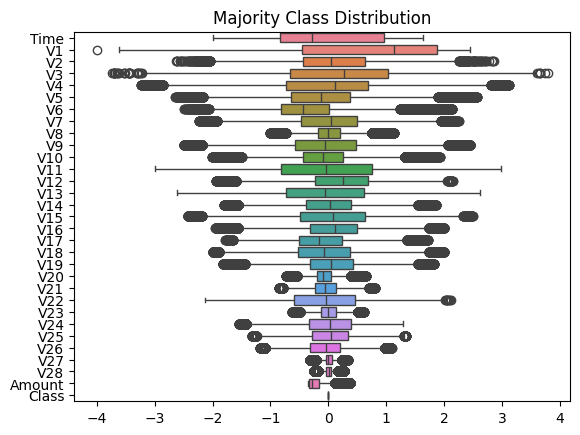

In [34]:
# Check majority distribution
sns.boxplot(data=df_majority_cleaned, orient='h')
plt.title('Majority Class Distribution')
plt.show()

In [36]:
# Combine the majority and minority classes
df_cleaned = pd.concat([fraud, df_majority_cleaned])

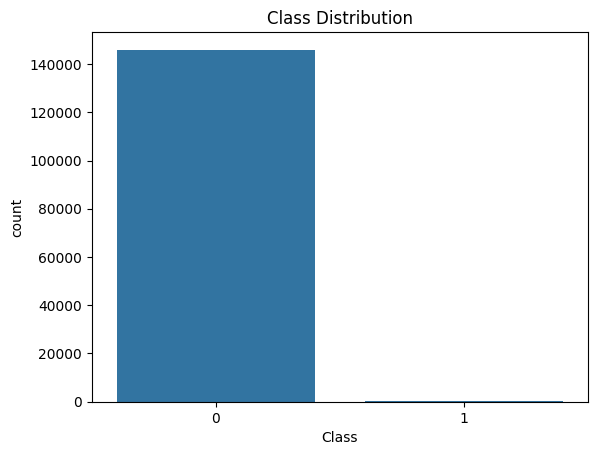

In [37]:
# Check the distribution of the combined classes
sns.countplot(x='Class', data=df_cleaned)
plt.title('Class Distribution')
plt.show()

In [41]:
# Split the data into features and labels
X = df_cleaned.drop('Class', axis=1)
y = df_cleaned['Class']

print(X.shape)
print(y.shape)

(146446, 30)
(146446,)


In [46]:
# Handle class imbalance
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print(X_rus.shape, y_rus.shape)
print(X_smote.shape, y_smote.shape)

(984, 30) (984,)
(291908, 30) (291908,)


In [49]:
# Reduce the dimensionality of the data
pca = PCA(n_components=2)
X_pca_rus = pca.fit_transform(X_rus)
X_pca_smote = pca.fit_transform(X_smote)

print(X_pca_rus.shape)
print(X_pca_smote.shape)

(984, 2)
(291908, 2)


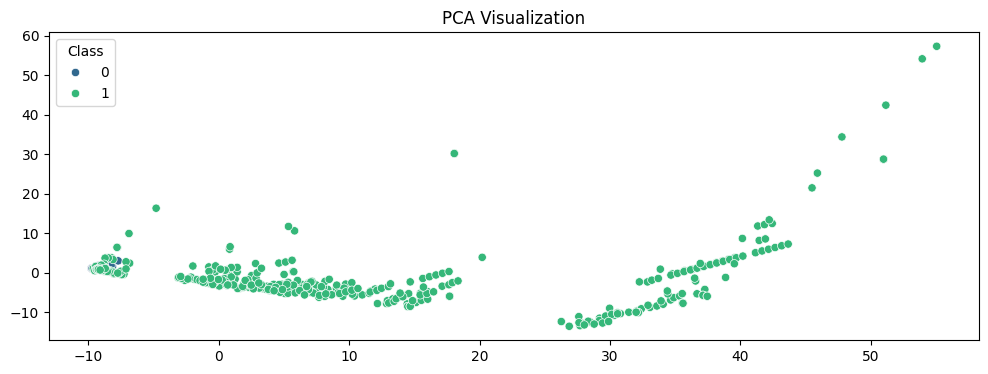

In [50]:
# Plot the data
plt.figure(figsize=(12, 4))
sns.scatterplot(x=X_pca_rus[:, 0], y=X_pca_rus[:, 1], hue=y_rus, palette='viridis')
plt.title('PCA Visualization')
plt.show()

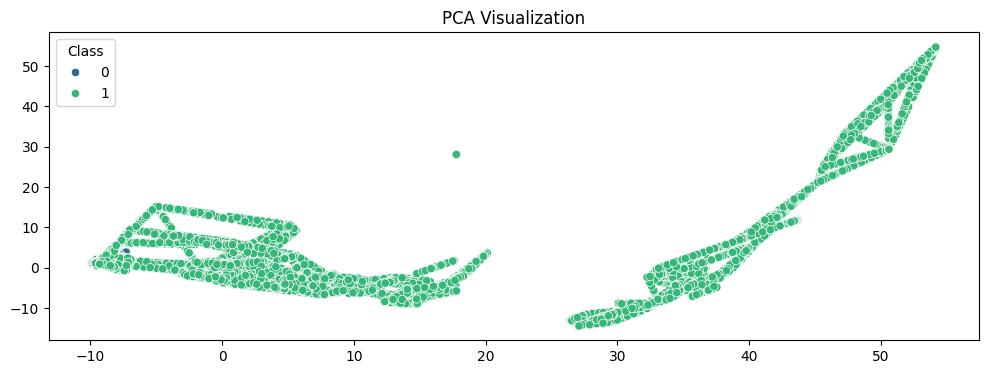

In [51]:
# Plot the data
plt.figure(figsize=(12, 4))
sns.scatterplot(x=X_pca_smote[:, 0], y=X_pca_smote[:, 1], hue=y_smote, palette='viridis')
plt.title('PCA Visualization')
plt.show()

In [68]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_rus, y_rus, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Cache the data
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [69]:
# Build the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

d:\anaconda3\envs\tensorflow\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5644 - loss: 1.3363 - val_accuracy: 0.8223 - val_loss: 0.4299
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6792 - loss: 0.7917 - val_accuracy: 0.8579 - val_loss: 0.3730
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7227 - loss: 0.6473 - val_accuracy: 0.8731 - val_loss: 0.3519
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7480 - loss: 0.5508 - val_accuracy: 0.8782 - val_loss: 0.3457
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7533 - loss: 0.5774 - val_accuracy: 0.8782 - val_loss: 0.3320
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8008 - loss: 0.4874 - val_accuracy: 0.8883 - val_loss: 0.3207
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8078 - loss: 0.4462 - val_accuracy: 0.8883 - val_loss: 0.3086
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8347 - loss: 0.4023 - val_accuracy: 0.8985 - val_loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        99
           1       1.00      0.81      0.89        98

    accuracy                           0.90       197
   macro avg       0.92      0.90      0.90       197
weighted avg       0.92      0.90      0.90       197



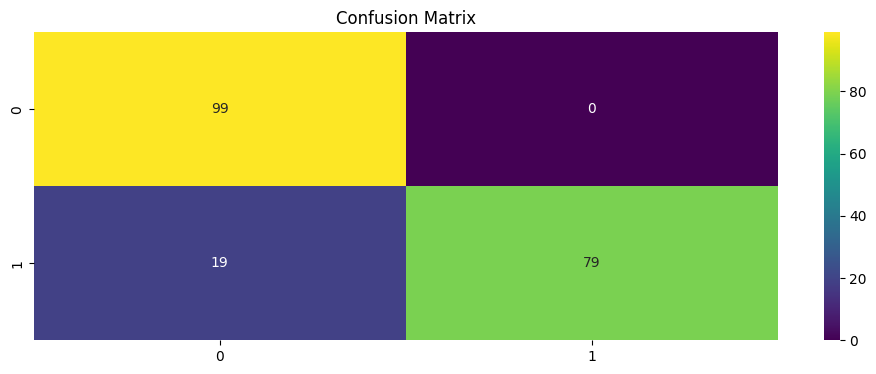

In [70]:
# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

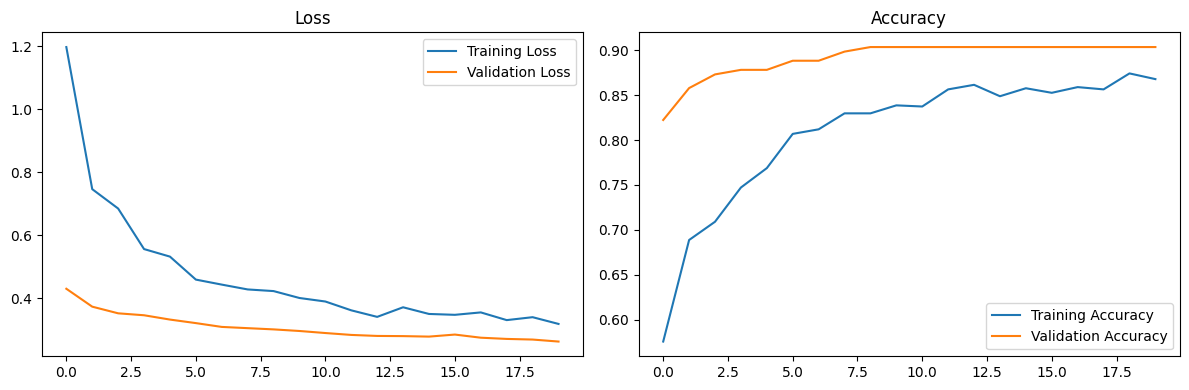

In [71]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

4577/4577 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    145954
           1       1.00      0.80      0.89       492

    accuracy                           1.00    146446
   macro avg       1.00      0.90      0.94    146446
weighted avg       1.00      1.00      1.00    146446



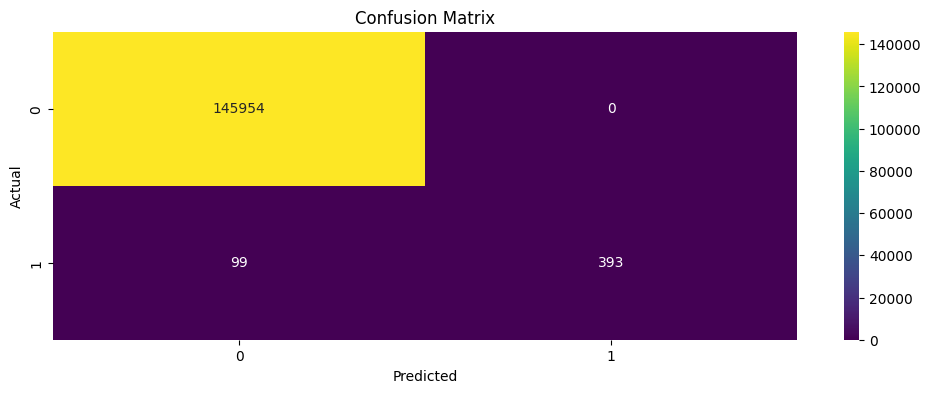

In [72]:
# Evaluate on whole dataset
X_org_pca = pca.transform(X)
y_pred = (model.predict(X_org_pca) > 0.5).astype('int32')
print(classification_report(y, y_pred))

plt.figure(figsize=(12, 4))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
# Save the model
model.save('credit_card_fraud_detection.h5')